In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sksurv.datasets
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
df = pd.read_csv('../../data/gcp_2.csv')
df.set_index(keys = 'TRR_ID_CODE', inplace = True)

In [5]:
df_train = df
df_test = df_train.sample(frac = 0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac = 0.2)
df_train = df_train.drop(df_val.index)

In [6]:
# Feature transforms

cols_standardize = ['AGE_DON', 'AGE', 'INIT_AGE','COLD_ISCH_KI',
                    'Transplant_Year', 'BUN_DON', 'DISTANCE', 'PO2_DON',
                   'CREAT_TRR', 'CREAT_DON', 'BMI_CALC', 'HEMATOCRIT_DON',
                   'PH_DON']

cols_leave = ['ECD_DONOR', 'HIST_HYPERTENS_DON', 'URINE_INF_DON',
              'DRMIS_2.0', 'HIST_CIG_DON', 'HTLV_DON_ND', 'REGION_2',
             'RDR1_4.0', 'DIABETES_DON', 'INOTROP_SUPPORT_DON', 'EBV_SEROSTATUS_P',
             'DEATH_MECH_DON_3', 'DR1_4', 'HIST_OTH_DRUG_DON', 'EDUCATION_5.0', 'DIAG_KI_3040.0',
             'DEATH_CIRCUM_DON_2', 'REGION_5', 'RDR1_13.0', 'DR1_13']


standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [7]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [8]:
get_target = lambda df: (df['GTIME_KI_YEARS'].values, df['GRF_STAT_NUM'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

### Neural net

In [9]:
n_nodes = 256
in_features = x_train.shape[1]
num_nodes = [n_nodes, n_nodes, n_nodes, n_nodes]
out_features = 1
batch_norm = True
dropout = 0.4
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

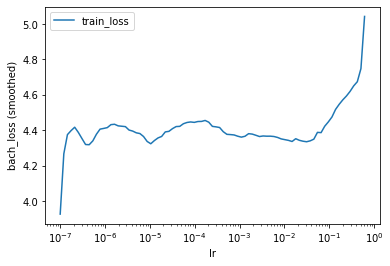

In [10]:
model = CoxPH(net, tt.optim.Adam)


batch_size = 128
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()




In [11]:
lrfinder.get_best_lr()

0.0001

In [12]:
model.optimizer.set_lr(0.0001)
model.optimizer.param_groups[0]['lr']

0.0001

In [13]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [14]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[15s / 15s],		train_loss: 4.1971,	val_loss: 3.9655
1:	[17s / 33s],		train_loss: 4.0949,	val_loss: 3.9510
2:	[16s / 50s],		train_loss: 4.0591,	val_loss: 3.9411
3:	[15s / 1m:5s],		train_loss: 4.0290,	val_loss: 3.9375
4:	[15s / 1m:21s],		train_loss: 4.0199,	val_loss: 3.9305
5:	[16s / 1m:37s],		train_loss: 4.0041,	val_loss: 3.9260
6:	[16s / 1m:53s],		train_loss: 3.9966,	val_loss: 3.9220
7:	[15s / 2m:9s],		train_loss: 3.9826,	val_loss: 3.9199
8:	[15s / 2m:24s],		train_loss: 3.9765,	val_loss: 3.9197
9:	[16s / 2m:41s],		train_loss: 3.9760,	val_loss: 3.9184
10:	[17s / 2m:58s],		train_loss: 3.9677,	val_loss: 3.9164
11:	[21s / 3m:19s],		train_loss: 3.9610,	val_loss: 3.9160
12:	[15s / 3m:35s],		train_loss: 3.9557,	val_loss: 3.9152
13:	[14s / 3m:50s],		train_loss: 3.9510,	val_loss: 3.9156
14:	[16s / 4m:6s],		train_loss: 3.9547,	val_loss: 3.9171
15:	[17s / 4m:23s],		train_loss: 3.9521,	val_loss: 3.9153
16:	[16s / 4m:40s],		train_loss: 3.9468,	val_loss: 3.9146
17:	[17s / 4m:57s],		train_loss: 3.9

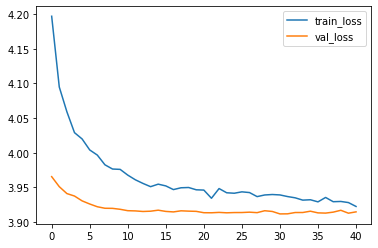

In [15]:

_ = log.plot()


### Prediction

In [16]:
_ = model.compute_baseline_hazards()

In [17]:
surv = model.predict_surv_df(x_test)

### Evaluation

In [18]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [19]:
ev.concordance_td()

0.63828841498003

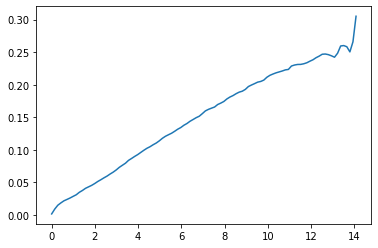

In [20]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [21]:
ev.integrated_brier_score(time_grid)

0.14919221363911622

In [22]:
ev.integrated_nbll(time_grid)

0.4569231913250121